In [1]:
!pip install konlpy

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 모듈 설치

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
from konlpy.tag import Okt
from tqdm import tqdm

## 한글

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## 데이터 불러오기

In [5]:
news = pd.read_csv('./drive/MyDrive/crawling_df.csv', index_col=0) 
news.tail()

,name,headline,date,change
419439,신한지주,신한 디지털 vs 국민 변화… 카드 리딩금융 승부수,2021-12-30,0
419440,신한지주,순혈주의 이어 유리천장도 깨진다…은행권에 부는 '여풍',2021-12-30,0
419441,신한지주,"“리딩금융 승자, 비은행이 가른다” 신한 vs KB, ‘보험 전쟁’",2021-12-30,0
419442,신한지주,은행 개발자 몸값 더 높아진다...부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
419443,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0


## 중복 제거

In [6]:
news.drop_duplicates(subset=['headline'], inplace=True, keep=False)
news.reset_index(drop=True, inplace=True)
news.tail(3)

,name,headline,date,change
244716,신한지주,"“리딩금융 승자, 비은행이 가른다” 신한 vs KB, ‘보험 전쟁’",2021-12-30,0
244717,신한지주,은행 개발자 몸값 더 높아진다...부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
244718,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0


## 주가 변동 별 분포 확인

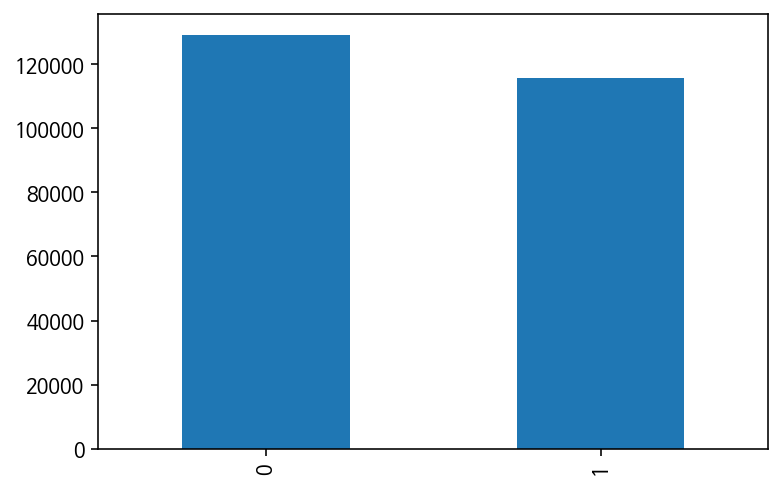

In [7]:
news['change'].value_counts().plot(kind = 'bar');

In [8]:
print(news.groupby('change').size().reset_index(name = 'count'))

   change   count
0       0  129183
1       1  115536


## 널값 확인

In [9]:
print(news.isnull().values.any()) # 널값 없음

False


In [10]:
news['date'] = pd.to_datetime(news['date'])

split_date = pd.to_datetime('2020-01-01')

train = news[news['date'] < split_date]
test = news[news['date'] >= split_date]

In [11]:
len(train), len(test)

(198058, 46661)

## 품사 별 분포 확인
- 조사, 형용사, 문장부호가 하나의 기준이 될 수 있기 때문에
- 일단은 전처리를 하지 않고

In [12]:
from collections import Counter, defaultdict
okt = Okt()

### 각 단어별 품사 카운트

In [13]:
okt.tagset # 어떤 품사가 있는지 살펴보기

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

### 주가 상승/하락 별 품사 카운트 확인

In [15]:
negVoca = defaultdict(Counter) # key : 형태소 value : dict()의 key: 단어 : 카운트
posVoca = defaultdict(Counter) # ex) 명사 - (바보 - (7))

# 뉴스 헤드라인 데이터 (token, 품사) 별로 카운팅 하기
for headline in tqdm(train['headline'][train['change'] == 0]):
    morphemes = okt.pos(headline) # headline 형태소 분석하기
    for (token, pos) in morphemes:
        negVoca[pos][token] += 1

for headline in tqdm(train['headline'][train['change'] == 1]):
    morphemes = okt.pos(headline) # headline 형태소 분석하기
    for (token, pos) in morphemes:
        posVoca[pos][token] += 1

100%|██████████| 92844/92844 [01:30<00:00, 1023.89it/s]


### 품사별 분포 시각화

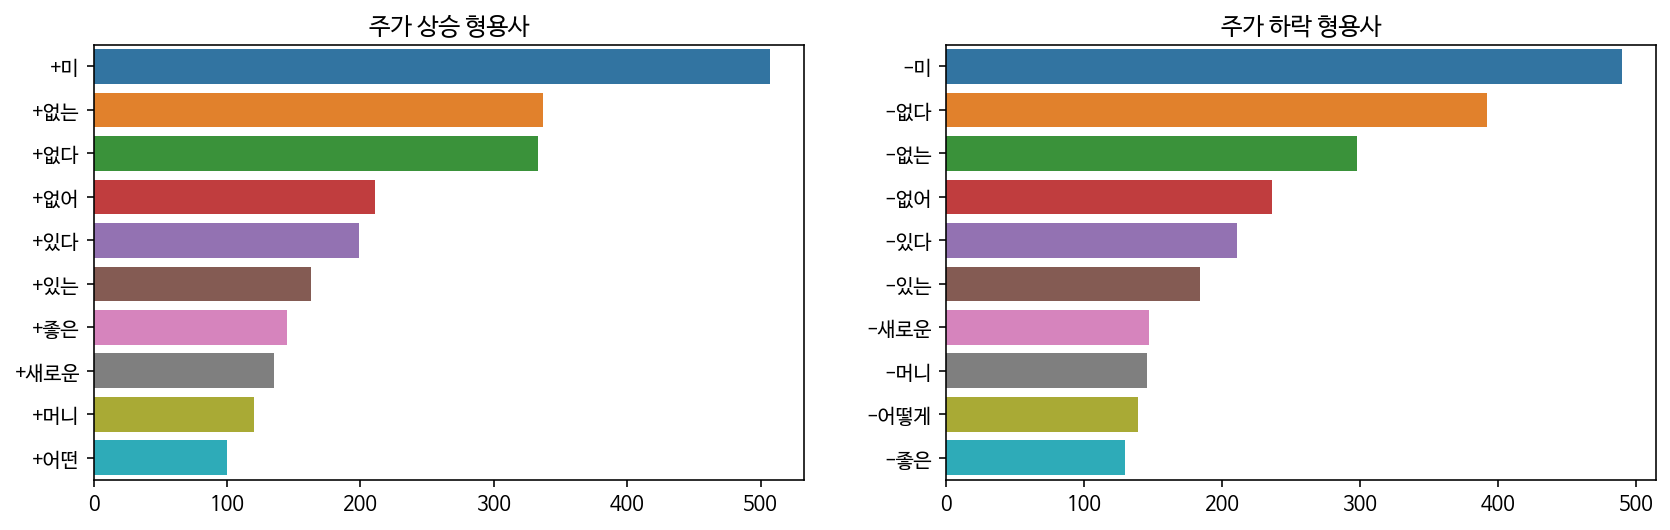

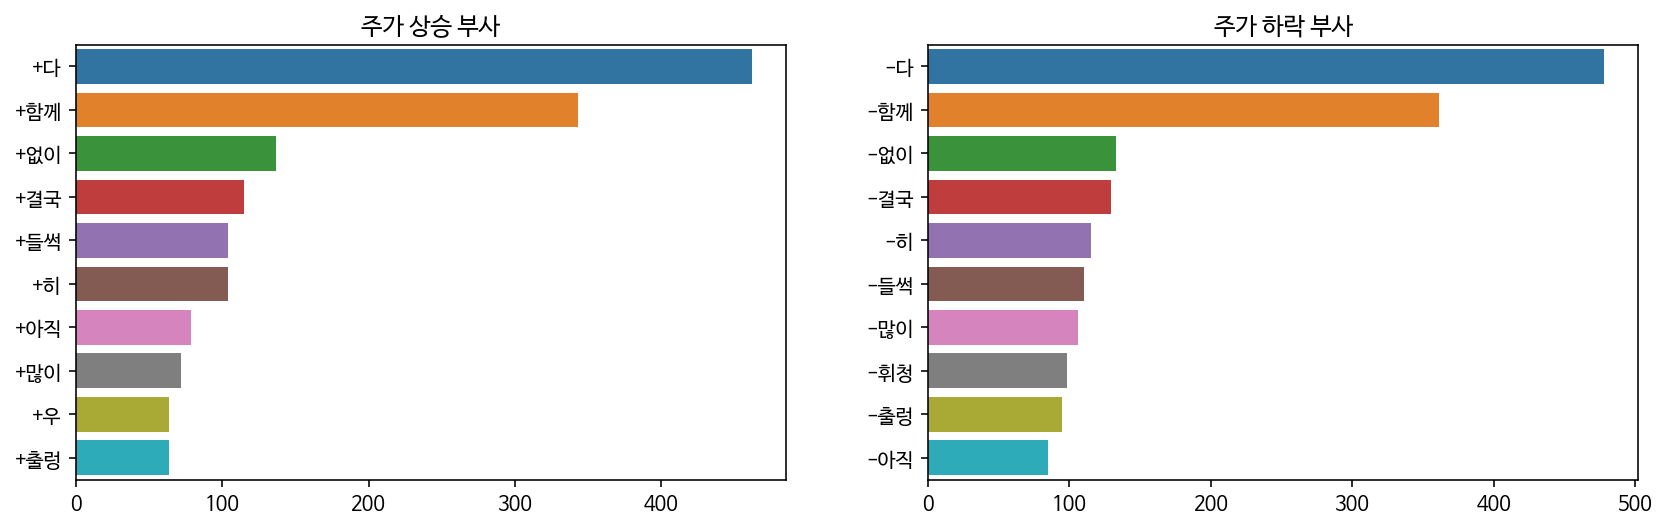

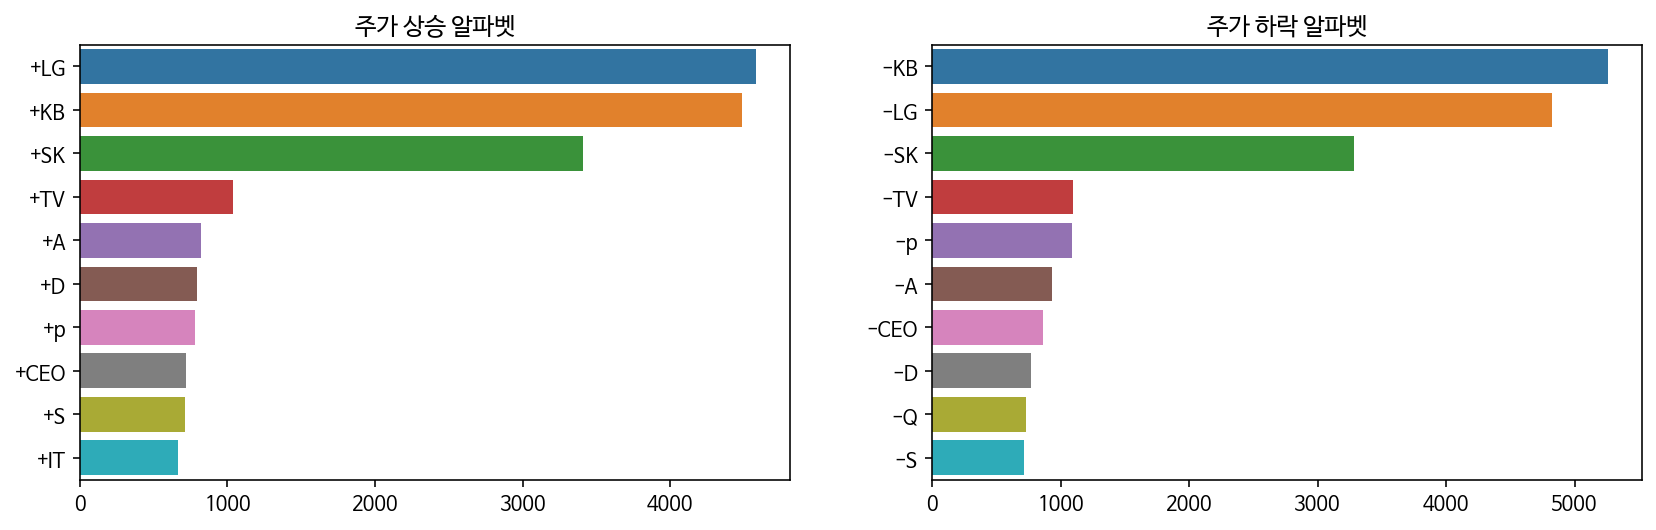

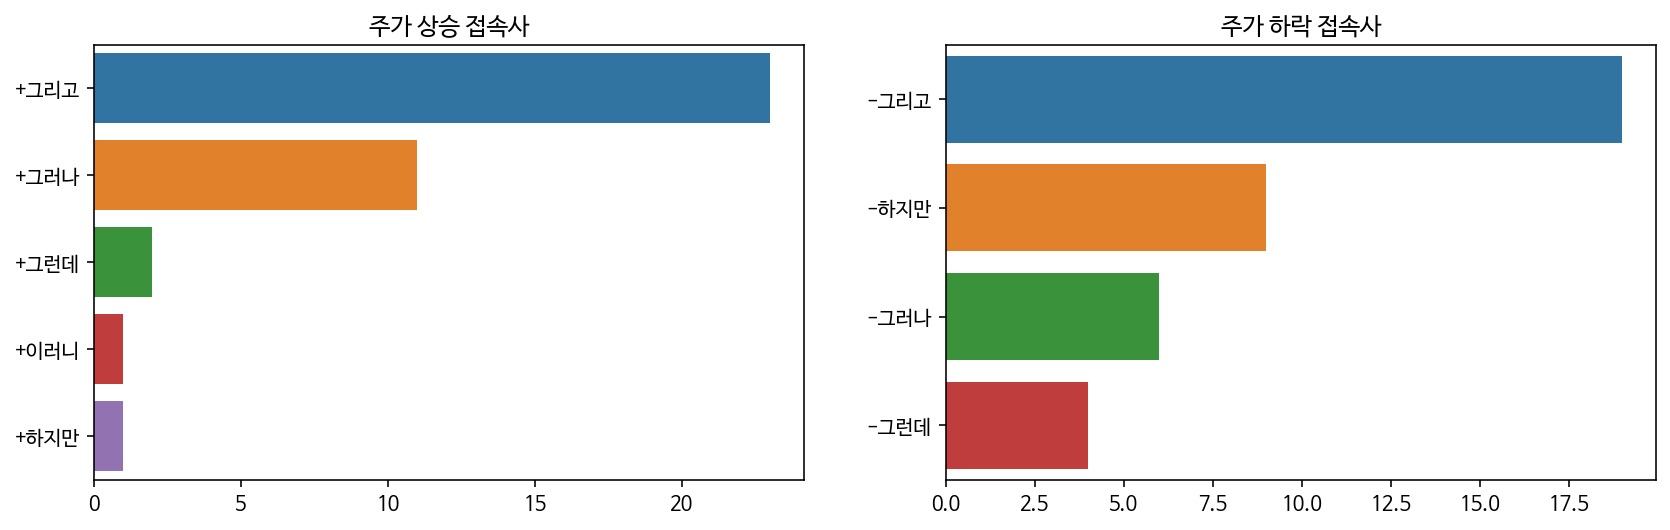

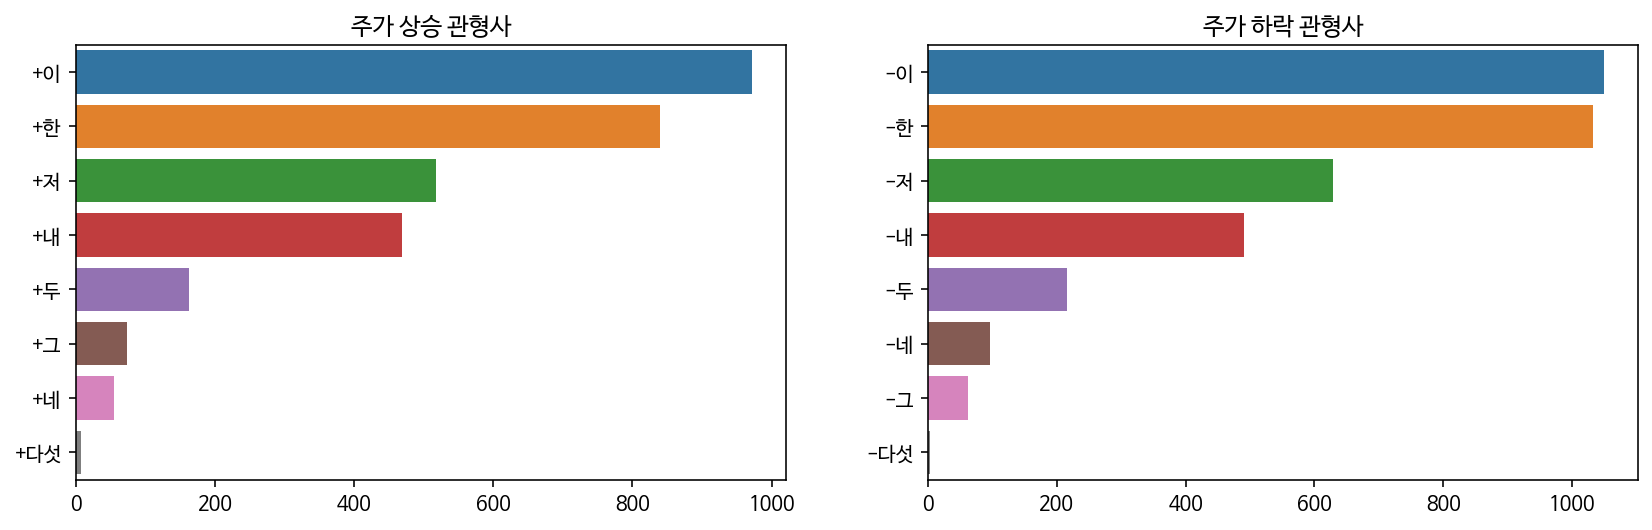

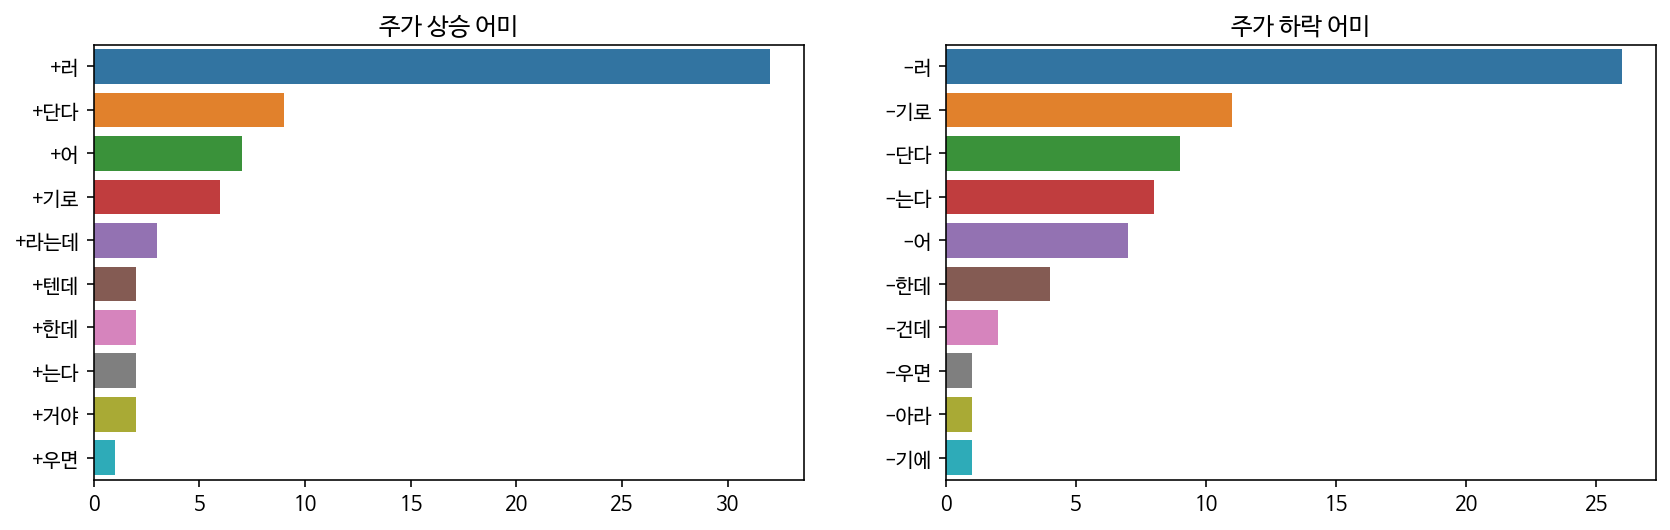

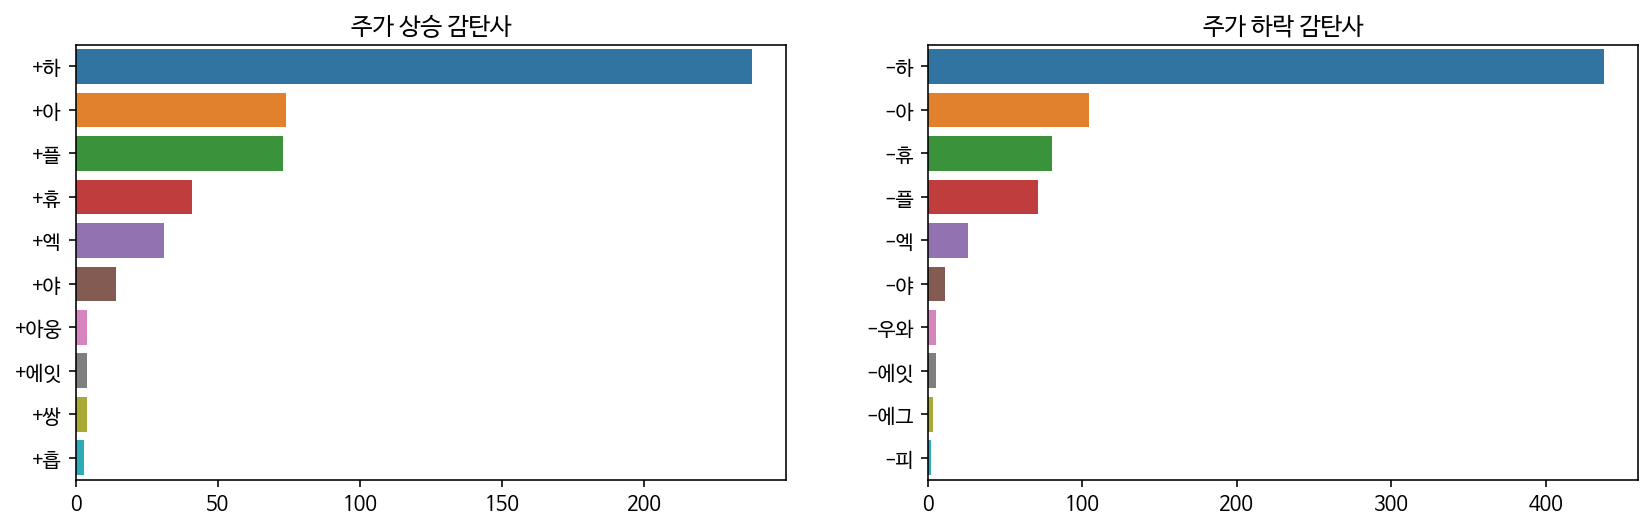

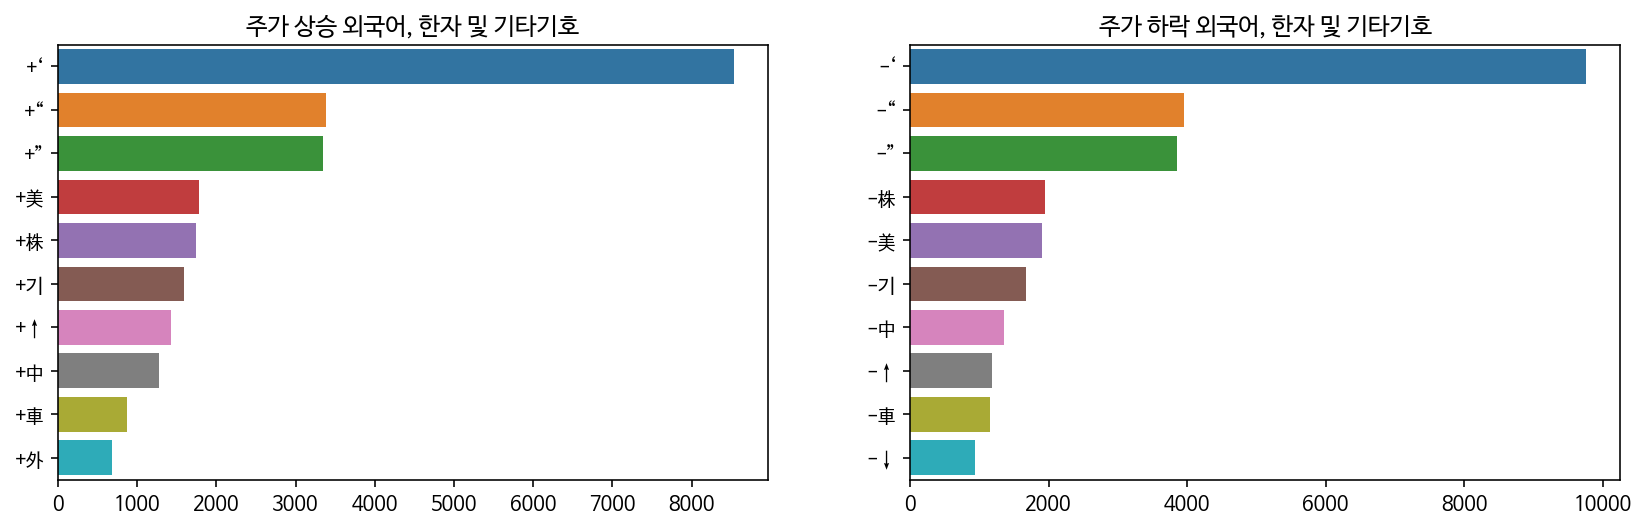

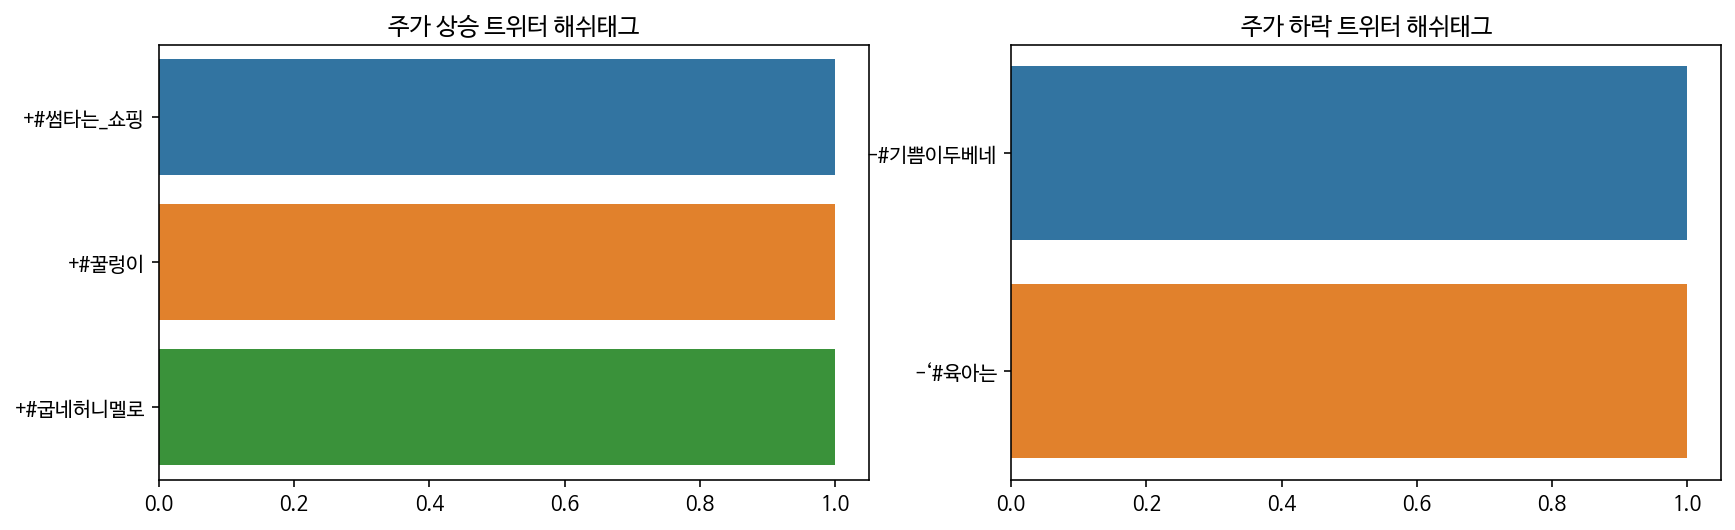

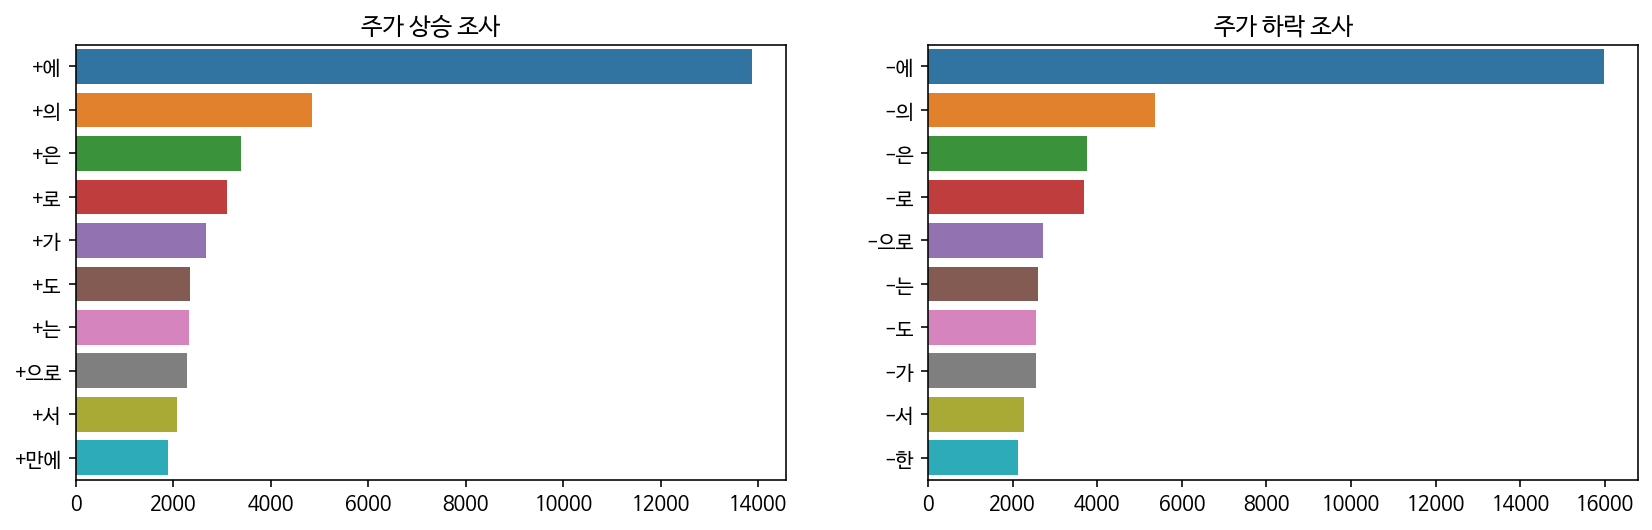

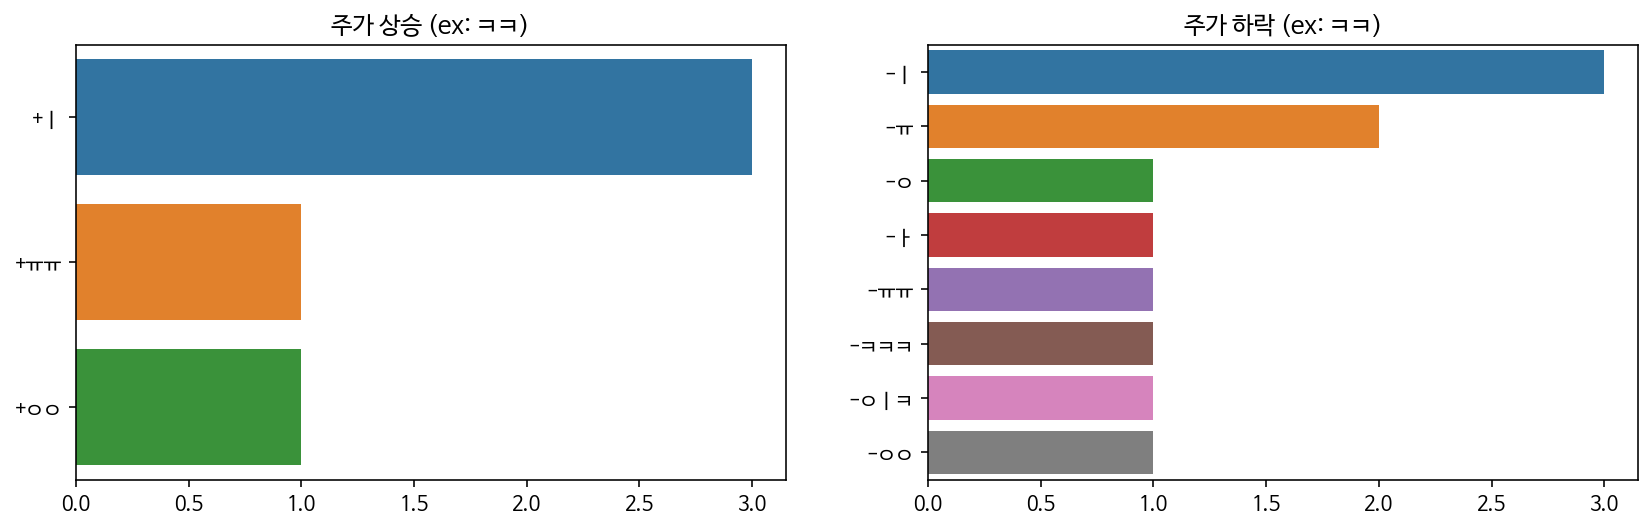

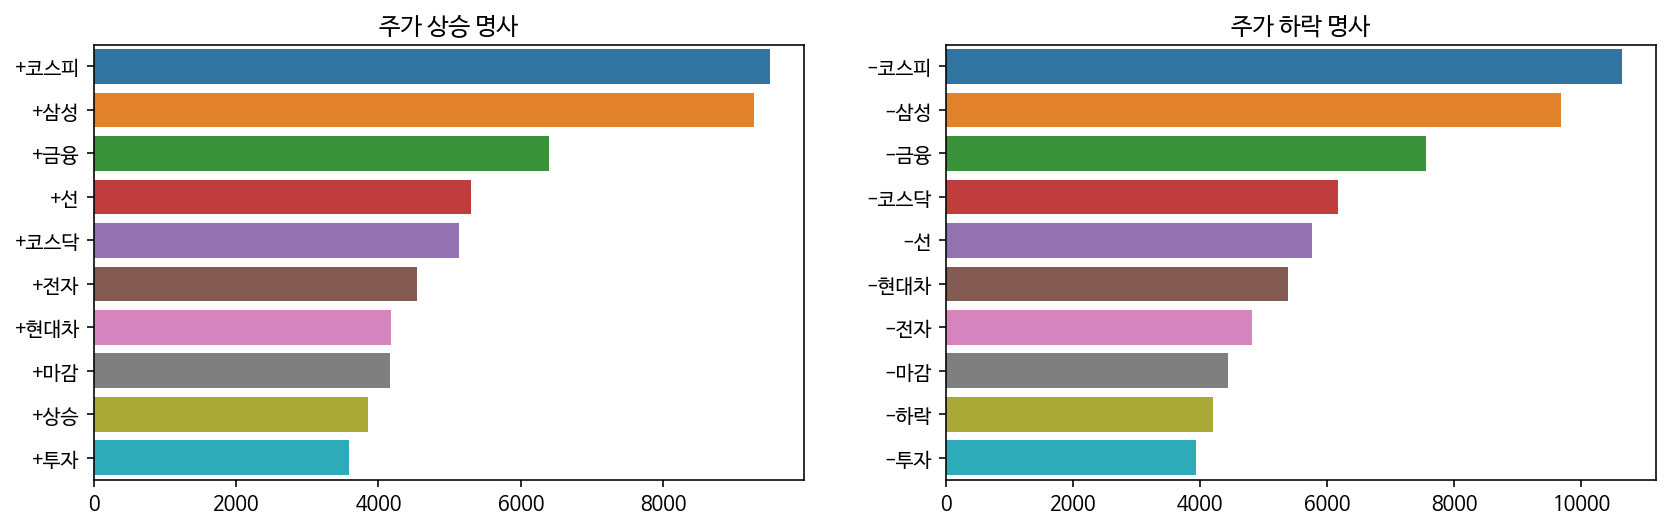

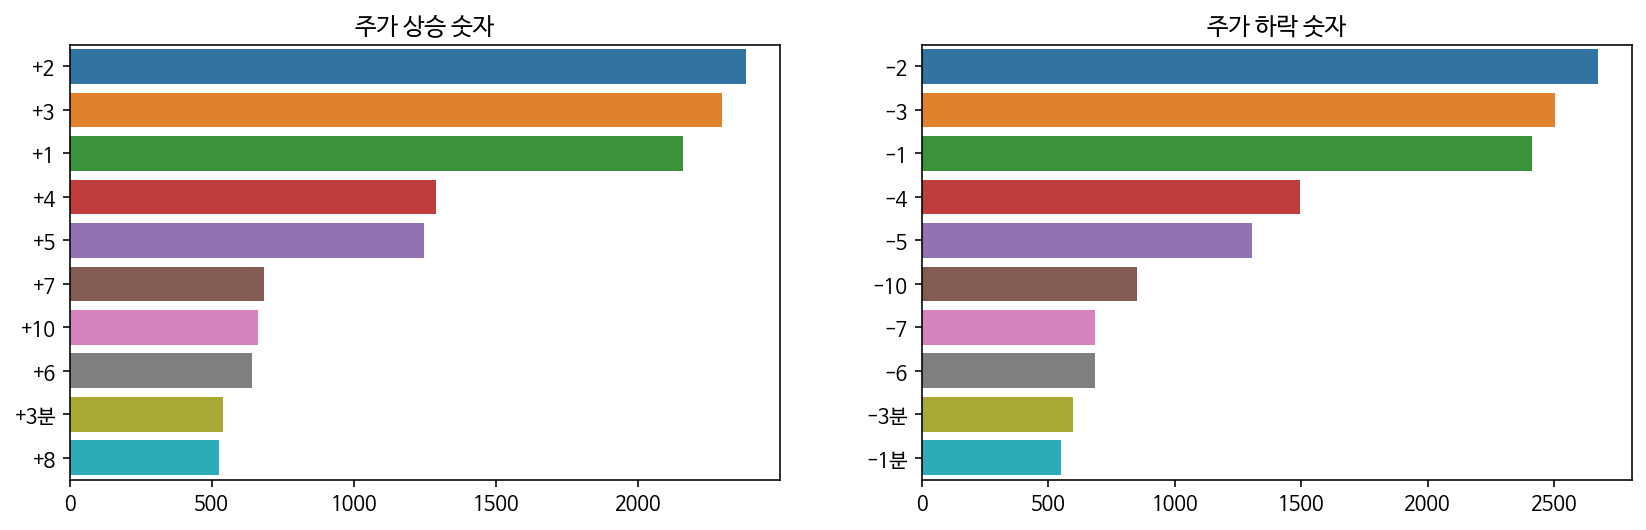

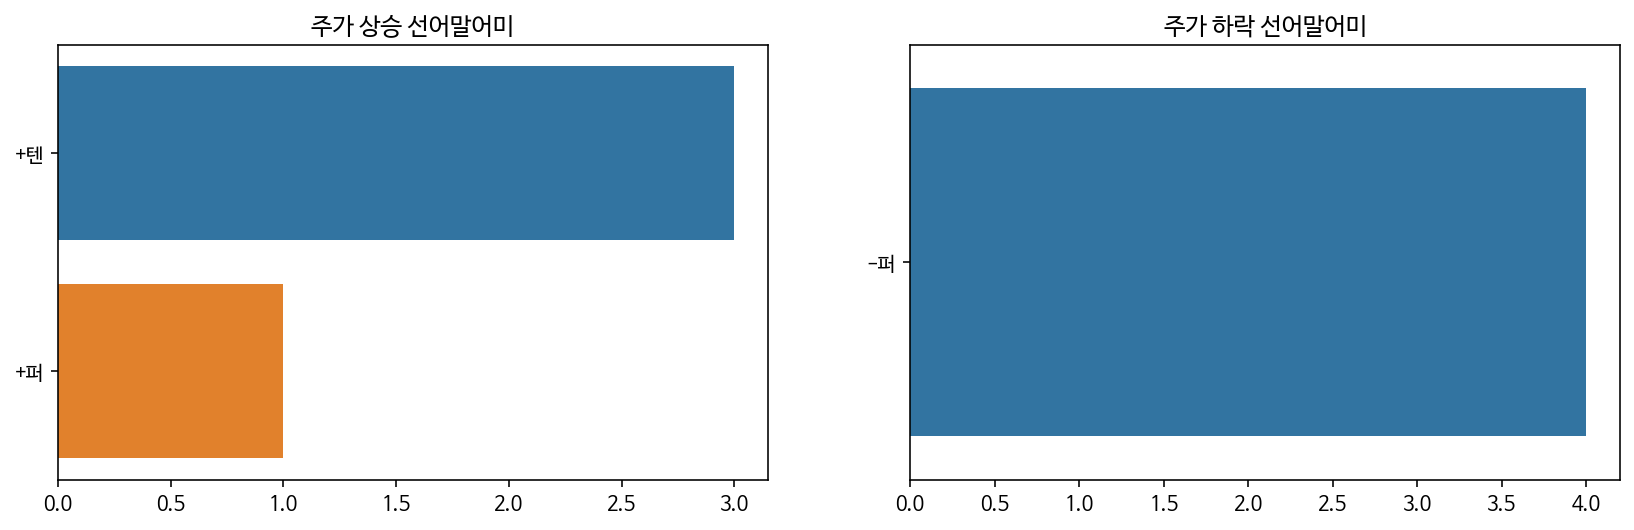

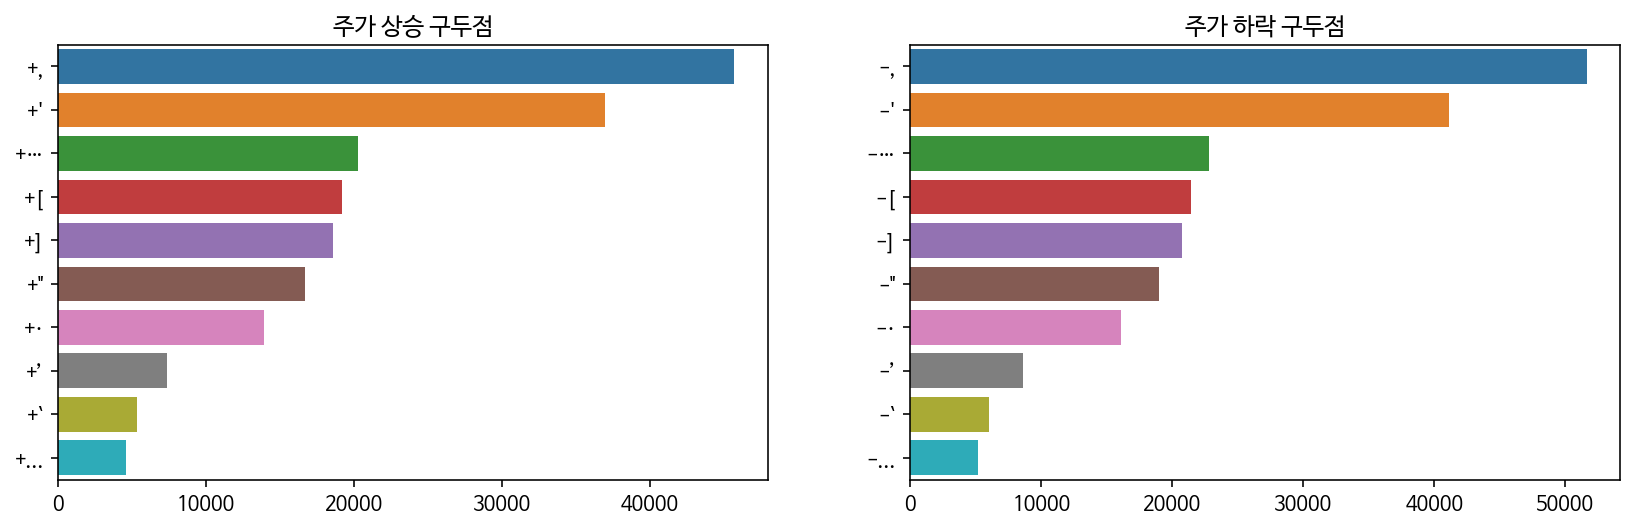

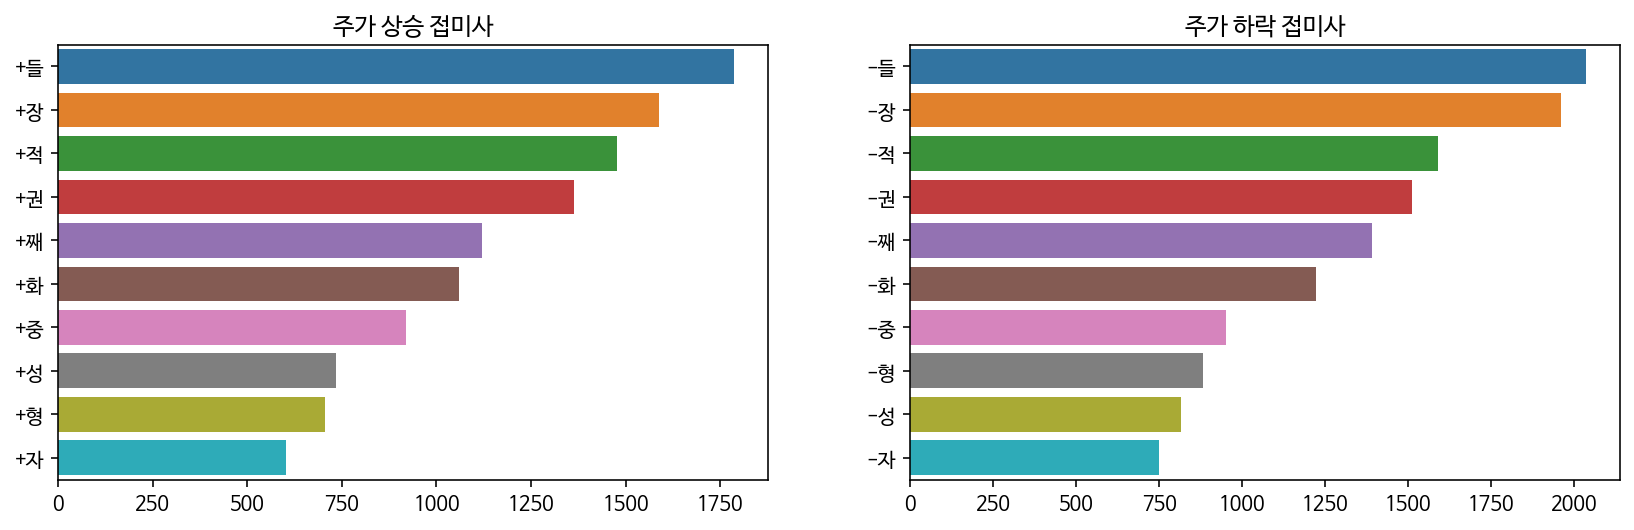

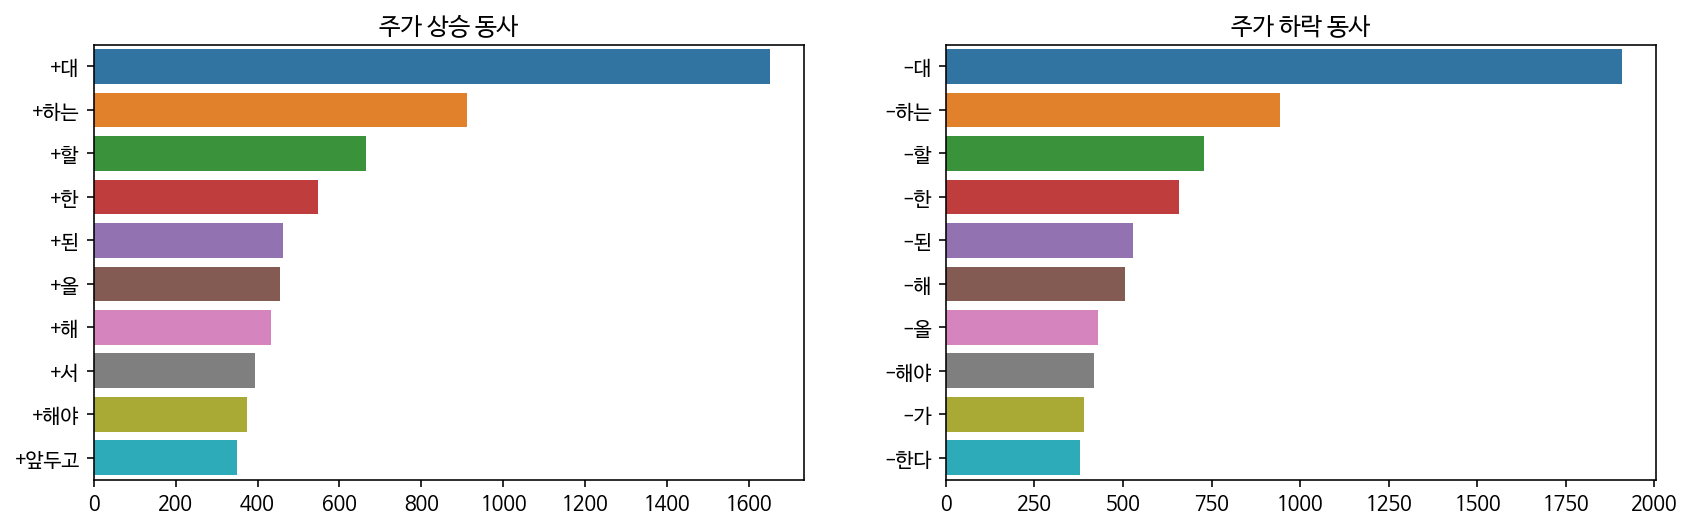

In [18]:
for pos, korPos in okt.tagset.items():
    # 품사당 빈도수가 가장 높은 10개만 그래표에 나타내 보겠다
    _pos = posVoca[pos].most_common()[:10]
    _neg = negVoca[pos].most_common()[:10]

    # 해당하는 품사에 데이터가 없다면 패스!
    if len(_pos) == 0 or len(_neg) == 0:
        continue
    
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # 품사별 토큰의 카운트를 가로그래프로 표시하기 
    sns.barplot([_[1] for _ in _pos], ["+" + _[0] for _ in _pos], ax=ax1)
    sns.barplot([_[1] for _ in _neg], ["-" + _[0] for _ in _neg], ax=ax2)

    ax1.title.set_text('주가 상승 ' + korPos)
    ax2.title.set_text('주가 하락 ' + korPos)

    plt.show()